In [1]:
import os
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as L
from IPython.display import clear_output
#ENV Stuff
from rocket import Rocket
import utils

%matplotlib inline

2024-06-11 15:47:53.858564: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 15:47:53.858592: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 15:47:53.859200: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-11 15:47:53.863114: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 15:47:54.459355: W tensorflow/compiler/tf2

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-06-11 15:47:55.118864: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-11 15:47:55.139879: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-11 15:47:55.140000: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Environment Setup

#### We are using Zhengxia Zou, Rocket-recycling with Reinforcement Learning, 2021

#### Repo Link: https://github.com/jiupinjia/rocket-recycling

We will be focusing on the landing problem with rockets



In [7]:
task = 'hover'
num_steps = 800 #Environment steps
env = Rocket(task=task, max_steps=num_steps, rocket_type='starship')
obs_N = env.state_dims #Observations are x, y, vx, vy, theta, vtheta, t, phi(nozzle angle), total 8
act_N = env.action_dims #Actions are 3 thrust values in 3 directions, total 9

tf_writer = tf.summary.create_file_writer('./logs/')

## Agent Setup

#### We wrote our own PPO-CLIP agent in Tensorflow 2
Actor            |  Critic
:-------------------------:|:-------------------------:
<img src="actor.png" alt="actor" width="200"/>  |  <img src="critic.png" alt="critic" width="200"/>

### Overall algorithm
* Initialize actor(policy), critic networks
* Collect trajectory(t=0 to T) in TRAJ
    * a = sample($\pi_{\theta_k}(a|s)$)
    * s', r, d = env.step(a)
    * logprob = $log(\pi_{\theta_k}(a|s)))$
* Calculate Advantage A using Generalized Advantage Estimation
* Calculate Reward-to-go RTG
* Update Actor
    * Get $log(\pi_\theta(a|s))$ using TRAJ
    * Calculate Diff: $log(\pi_\theta(a|s))-log(\pi_{\theta_k}(a|s))$
    * Calculate Ratio: exp(diff)
    * Calculate Loss: $\mathbb{E}_t$[min(Ratio\*A, clip(Ratio, 1-$\epsilon$, 1+$\epsilon$)\*A)]
    * Perform gradient descent on -Loss
* Update Critic
    * Get $V(s)$ using critic
    * Calculate Diff: $V(s)-RTG$
    * Calculate Loss: MSE(Diff)
    * Perform gradient descent on Loss

In [8]:
def createActorCritic(obs_N, act_N):
    """
    Just a combined model
    """
    #Preprocess
    inp = keras.Input(shape=obs_N, name='obs_input')
    #Actor
    ac = L.Dense(64, activation='relu', name='Afc1')(inp)
    ac = L.Dense(64, activation='relu', name='Afc2')(ac)
    ac = L.Dense(act_N, activation='softmax', name='Afc3')(ac)
    #Critic
    cr = L.Dense(64, activation='relu', name='Cfc1')(inp)
    cr = L.Dense(64, activation='relu', name='Cfc2')(cr)
    cr = L.Dense(1, activation='linear', name='Cfc3')(cr)
    model = keras.Model(inputs=inp, outputs=[ac, cr], name='actor_critic')
    return model

class PPOClipAgent:
    def __init__(self, obs_N, act_N, lr=1e-3, gamma=0.99, clip=0.2, lmbda=0.98, entropy=1e-3, tf_writer=None):
        self.writer = tf_writer
        #Agent parameters
        self.obs_N = obs_N
        self.act_N = act_N
        self.gamma = gamma
        #Network
        self.actor_critic = createActorCritic(obs_N, act_N)
        self.optimizer = keras.optimizers.Adam(learning_rate=lr, clipvalue=1)
        #PPO specifics
        self.clip = clip
        self.lmbda = lmbda
        self.entropy = entropy

    def get_action(self, obs):
        """
        Return a discrete action from actor's softmax distribution
        """
        action_probs, _ = self.actor_critic(np.atleast_2d(obs))
        action_probs = action_probs.numpy().flatten()
        action = np.random.choice(np.arange(self.act_N), p=action_probs)
        return action, action_probs[action]
    
    def get_bestaction(self, obs):
        """
        Returns the amax
        """
        action_probs, _ = self.actor_critic(np.atleast_2d(obs))
        action = tf.argmax(action_probs.numpy().flatten())
        return action
    
    def get_rtg(self, r):
        """
        Get rewards to go of a batch
        Which is nothing but discounted rewards from s
        """
        rtg = np.zeros(len(r)+1)
        for i in reversed(range(len(r))):
            rtg[i] = r[i] + self.gamma*rtg[i+1]
        return rtg[:-1]

    def get_gae(self, s, r, next_s, done):
        """
        Get generalized advantage estimation of a batch
        """
        #Get values
        _, v_vals_s = self.actor_critic(np.atleast_2d(s))
        #This is essentially shifted v_vals_s along with final state, used here to make implementation easy
        _, v_vals_next_s = self.actor_critic(np.atleast_2d(next_s))
        v_vals_s = v_vals_s.numpy()
        v_vals_next_s = v_vals_next_s.numpy()
        adv = np.zeros(len(r)+1)
        for i in reversed(range(len(r))):
            #td_t = r_t + gamma*V(s_t+1) - V(s_t)
            td_err = r[i] + self.gamma*v_vals_next_s[i]*(1-done[i]) - v_vals_s[i]
            #A_t = td_t + gamma*lambda*A_t+1
            adv[i] = td_err + self.gamma*self.lmbda*adv[i+1]
        return adv[:-1] 
    
    def train_step(self, s, a, probs, rtg, adv):
        """
        Train using experiences
        """
        rtg = tf.constant(tf.cast(rtg, tf.float32))
        adv = tf.constant(tf.cast(adv, tf.float32))
        probs = tf.constant(tf.squeeze(probs))
        #logPi_k(a|s)
        logprobs = tf.squeeze(tf.math.log(probs+1e-9)) #Prevents NaN value
        #Updates
        learnables = self.actor_critic.trainable_variables
        with tf.GradientTape() as tape:
            actor_loss, critic_loss = self.total_loss(s, a, logprobs, rtg, adv)
            loss = actor_loss + critic_loss
        grads = tape.gradient(loss, learnables)
        self.optimizer.apply_gradients(zip(grads, learnables))
            
        return actor_loss, critic_loss
    
    def total_loss(self, s, a, logprobs, rtg, adv):
        """
        Returns actor and critic losses
        """
        curr_probs, v_vals_s = self.actor_critic(s, training=True)
        #For Actor
        curr_probs = tf.reduce_sum(curr_probs*tf.one_hot(a, self.act_N), axis=1)
        curr_logprobs = tf.math.log(curr_probs+1e-9) #Prevents NaN value
        ratio = tf.math.exp(curr_logprobs-logprobs)
        #Surrogates
        surrogate1 = ratio*adv
        surrogate2 = tf.where(adv>0, (1+self.clip)*adv, (1-self.clip)*adv)
        #Loss is the mean of minimum
        clip_loss = tf.math.reduce_mean(tf.math.minimum(surrogate1, surrogate2))
        #For exploration, calculate entropy value
        entropy = tf.math.reduce_mean(-curr_probs*curr_logprobs)
        #Actor loss is negative for gradient ascent. Entropy is added overall
        actor_loss = -clip_loss + self.entropy*entropy

        #For Critic
        v_vals_s = tf.squeeze(v_vals_s)
        #Critic loss is mean(r-v)^2
        critic_loss = tf.math.reduce_mean(tf.math.square(rtg - v_vals_s))  
        
        return actor_loss, critic_loss

In [9]:
def new_state(state):
    """
    Function to generate new state
    Following Zhengxia's implementation
    """
    L = 7
    scale = 1
    PI = 3.1415927410125732
    x = state*scale
    h = [x]
    for i in range(L):
        x_sin = tf.math.sin(2**i * PI * x)
        x_cos = tf.math.cos(2**i * PI * x)
        h.append(x_sin)
        h.append(x_cos)
    return tf.concat(h, axis=-1)/scale

new_obs_N = obs_N*(7*2+1)

In [10]:
#Removing time dimension
agent = PPOClipAgent(new_obs_N, act_N, lr=1e-3, gamma=0.99, lmbda=0.97, entropy=5e-3)

In [11]:
#If you want to load the weight
agent.actor_critic.load_weights("./models/actor_critic_{}_best".format(task))

## Buffer

In [12]:
class CUSTBuffer:
    def __init__(self):
        """
        Stores everything in a big array
        But can separate out into batches
        """
        self.create_buffers()
    
    def store(self, s, a, r, next_s, done, probs):
        """
        Store into the big array
        """
        self.s_buff.append(s)
        self.a_buff.append(a)
        self.r_buff.append(r)
        self.next_s_buff.append(next_s)
        self.done_buff.append(done)
        self.probs_buff.append(probs)
        
    def store_indexes(self, length):
        """
        Stores the start index of next batch
        """
        self.indexes.append(self.indexes[-1]+length+1)
    
    def get_batch(self, index):
        """
        Get data from batch number index
        """
        start_index = self.indexes[index]
        end_index = self.indexes[index+1]
        s = np.array(self.s_buff[start_index:end_index])
        a = np.array(self.a_buff[start_index:end_index])
        r = np.array(self.r_buff[start_index:end_index])
        next_s = np.array(self.next_s_buff[start_index:end_index])
        done = np.array(self.done_buff[start_index:end_index])
        probs = np.array(self.probs_buff[start_index:end_index])
        return s, a, r, next_s, done, probs, start_index, end_index
    
    def get_full_data(self):
        """
        Returns all the data
        """
        s = np.array(self.s_buff)
        a = np.array(self.a_buff)
        r = np.array(self.r_buff)
        next_s = np.array(self.next_s_buff)
        done = np.array(self.done_buff)
        probs = np.array(self.probs_buff)
        return s, a, r, next_s, done, probs

    def max_length(self):
        return len(self.r_buff)
    
    def create_buffers(self):
        """
        Creates new buffer lists
        """
        self.s_buff = []
        self.a_buff = []
        self.r_buff = []
        self.next_s_buff = []
        self.done_buff = []
        self.probs_buff = []
        #Always batch+1 length
        self.indexes = [0]

In [13]:
buffer = CUSTBuffer()

## Sample Generation

In [14]:
def generate_samples(env, agent, buffer):
    """
    Runs the environment and stores in buffer
    
    """
    s = new_state(env.reset()) #Removing time dimension
    cum_rew = 0
    for t in range(env.max_steps):
        #Get action
        a, a_prob = agent.get_action(s)
        #Step env forward
        next_s, r, done, info = env.step(a)
        next_s = new_state(next_s) #Removing time dimension
        #Batch collect samples
        buffer.store(s, a, r, next_s, done, a_prob)
        #Set next state
        s = next_s
        cum_rew += r
        #If complete break out of current episode
        if done:
            break
    #Add length to buffer
    buffer.store_indexes(t)
    #Return total reward
    return cum_rew

## Training

In [15]:
#Reset final layers
def reset_layer_weights(layer):
    kernel_init = tf.keras.initializers.GlorotUniform(np.random.randint(100))
    bias_init = tf.keras.initializers.GlorotUniform(np.random.randint(100))
    
    layer.kernel.assign(kernel_init(layer.kernel.shape))
    layer.bias.assign(bias_init(layer.bias.shape))

In [16]:
reset_layer_weights(agent.actor_critic.get_layer('Afc3'))

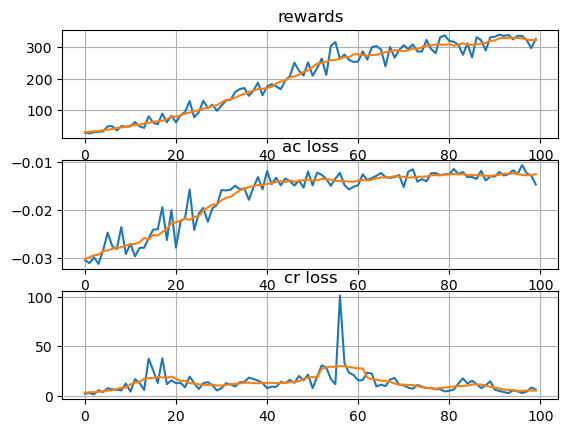

Stopped: Iteration: 100, Reward: 138.39082152765437


In [18]:
num_iters = 10000 #Training iterations
num_epochs = 10    #Number of gradient steps
num_eps = 5       #Number of episodes to run
train_rewards = []
actor_losses = []
critic_losses = []
try:
    for it in range(num_iters):
        #Clear buffer first, this is necessary since we have on-policy algorithm
        buffer.create_buffers()

        #Run num_eps times
        cum_rew = 0
        for ep in range(num_eps):
            cum_rew += generate_samples(env, agent, buffer)

        #Get necessary data
        max_len = buffer.max_length()
        rtg = np.zeros(max_len)
        adv = np.zeros(max_len)
        for ep in range(num_eps):
            s, a, r, ns, done, _, si, ei = buffer.get_batch(ep)
            rtg[si:ei] = agent.get_rtg(r)
            adv[si:ei] = agent.get_gae(s, r, ns, done)
        #On the full set of data
        s, a, r, ns, done, probs = buffer.get_full_data()
        #Advantage normalization on full data
        adv = (adv-adv.mean())/(adv.std()+1e-9)

        #Train agent
        a_loss_mean = 0
        c_loss_mean = 0    
        for epoch in range(num_epochs):
            a_loss, c_loss = agent.train_step(s, a, probs, rtg, adv)
            a_loss_mean += a_loss
            c_loss_mean += c_loss        
        #Utilities
        train_rewards.append(cum_rew/num_eps)
        actor_losses.append(a_loss_mean/num_epochs)
        critic_losses.append(c_loss_mean/num_epochs)
        clear_output(True)
        plt.subplot(3, 1, 1)
        plt.title("rewards")
        plt.plot(train_rewards)
        plt.plot(utils.moving_avg(train_rewards, N=10))
        plt.grid()
        plt.subplot(3, 1, 2)
        plt.title("ac loss")
        plt.plot(actor_losses)
        plt.plot(utils.moving_avg(actor_losses, N=10))
        plt.grid()
        plt.subplot(3, 1, 3)
        plt.title("cr loss")
        plt.plot(critic_losses)
        plt.plot(utils.moving_avg(critic_losses, N=10))
        plt.grid()
        plt.show()
        print('Iteration: {}, Reward: {}'.format(it, cum_rew/num_eps))

        with tf_writer.as_default():
            tf.summary.scalar('reward', cum_rew/num_eps, step = it)
            tf.summary.scalar('actor loss', a_loss_mean/num_epochs, step = it)
            tf.summary.scalar('critic loss', c_loss_mean/num_epochs, step = it)

except KeyboardInterrupt:
    clear_output(True)
    plt.subplot(3, 1, 1)
    plt.title("rewards")
    plt.plot(train_rewards)
    plt.plot(utils.moving_avg(train_rewards, N=10))
    plt.grid()
    plt.subplot(3, 1, 2)
    plt.title("ac loss")
    plt.plot(actor_losses)
    plt.plot(utils.moving_avg(actor_losses, N=10))
    plt.grid()
    plt.subplot(3, 1, 3)
    plt.title("cr loss")
    plt.plot(critic_losses)
    plt.plot(utils.moving_avg(critic_losses, N=10))
    plt.grid()
    plt.show()
    print('Stopped: Iteration: {}, Reward: {}'.format(it, cum_rew/num_eps))

    with tf_writer.as_default():
        tf.summary.scalar('reward', cum_rew/num_eps, step = it)
        tf.summary.scalar('actor loss', a_loss_mean/num_epochs, step = it)
        tf.summary.scalar('critic loss', c_loss_mean/num_epochs, step = it)
   

## Evaluation

In [21]:
task = 'hover'
num_steps = 800 #Environment steps
env = Rocket(task=task, max_steps=num_steps, rocket_type='starship')
# agent.actor_critic.load_weights("./models/actor_critic_{}_best".format(task))
video_name = 'video{}.mp4'.format(task)
s = env.reset()
frame_0, frame_1 = env.render()
height, width, layers = frame_0.shape
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(video_name, fourcc, 60, (width,height))

cum_reward = 0
for t in range(num_steps):
    a = agent.get_bestaction(new_state(s))
    s, r, done, _= env.step(a)
    cum_reward += r
    frame_0, frame_1 = env.render()
    cv2.imshow('fr', frame_0[:,:,::-1])
    video.write(frame_0[:,:,::-1])
    cv2.waitKey(1)
    cv2.imshow('fr', frame_1[:,:,::-1])
    video.write(frame_1[:,:,::-1])
    cv2.waitKey(1)
    if done:
        break
    if env.already_crash:
        break
video.release()
clear_output()
print("Total Reward: {}".format(cum_reward))

Total Reward: 349.92939900863337


In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.avi','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [19]:
agent.actor_critic.save_weights("./models/actor_critic_{}_best".format(task))

In [ ]:
agent.entropy=1e-5